In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('dataset_estudiantes.csv')
df.head()


,horas_estudio_semanal,nota_anterior,tasa_asistencia,horas_sueno,edad,nivel_dificultad,tiene_tutor,horario_estudio_preferido,estilo_aprendizaje,nota_final,aprobado
0,8.957476,48.830601,86.640182,6.675694,25,Fácil,Sí,Tarde,Lectura/Escritura,84.4,1
1,11.042524,80.825707,83.449655,4.616844,18,Difícil,No,Tarde,NaN,72.0,1
2,4.510776,90.383694,74.623607,7.755246,25,Fácil,No,Mañana,Lectura/Escritura,80.0,1
3,6.647213,81.878257,82.849841,8.592826,23,Fácil,No,NaN,Visual,78.2,1
4,1.000000,66.254179,54.539935,6.671840,21,Medio,No,NaN,Auditivo,66.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   horas_estudio_semanal      1000 non-null   float64
 1   nota_anterior              1000 non-null   float64
 2   tasa_asistencia            1000 non-null   float64
 3   horas_sueno                850 non-null    float64
 4   edad                       1000 non-null   int64  
 5   nivel_dificultad           1000 non-null   object 
 6   tiene_tutor                1000 non-null   object 
 7   horario_estudio_preferido  900 non-null    object 
 8   estilo_aprendizaje         950 non-null    object 
 9   nota_final                 1000 non-null   float64
 10  aprobado                   1000 non-null   int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 86.1+ KB


In [4]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols, cat_cols

(Index(['horas_estudio_semanal', 'nota_anterior', 'tasa_asistencia',
        'horas_sueno', 'edad', 'nota_final', 'aprobado'],
       dtype='object'),
 Index(['nivel_dificultad', 'tiene_tutor', 'horario_estudio_preferido',
        'estilo_aprendizaje'],
       dtype='object'))

In [5]:
for col in cat_cols:
    print(f" \n----------- ESTAMOS ANALIZANDO LA COLUMNA: '{col}' -----------\n")
    print(f"Valores únicos: {df[col].unique()}\n")
    print("Frecuencias de los valores únicos de las categorías:")
    display(df[col].value_counts())

 
----------- ESTAMOS ANALIZANDO LA COLUMNA: 'nivel_dificultad' -----------

Valores únicos: ['Fácil' 'Difícil' 'Medio']

Frecuencias de los valores únicos de las categorías:


nivel_dificultad
Medio      504
Fácil      313
Difícil    183
Name: count, dtype: int64

 
----------- ESTAMOS ANALIZANDO LA COLUMNA: 'tiene_tutor' -----------

Valores únicos: ['Sí' 'No']

Frecuencias de los valores únicos de las categorías:


tiene_tutor
No    597
Sí    403
Name: count, dtype: int64

 
----------- ESTAMOS ANALIZANDO LA COLUMNA: 'horario_estudio_preferido' -----------

Valores únicos: ['Tarde' 'Mañana' nan 'Noche']

Frecuencias de los valores únicos de las categorías:


horario_estudio_preferido
Noche     344
Tarde     337
Mañana    219
Name: count, dtype: int64

 
----------- ESTAMOS ANALIZANDO LA COLUMNA: 'estilo_aprendizaje' -----------

Valores únicos: ['Lectura/Escritura' nan 'Visual' 'Auditivo' 'Kinestésico']

Frecuencias de los valores únicos de las categorías:


estilo_aprendizaje
Visual               363
Auditivo             254
Kinestésico          178
Lectura/Escritura    155
Name: count, dtype: int64

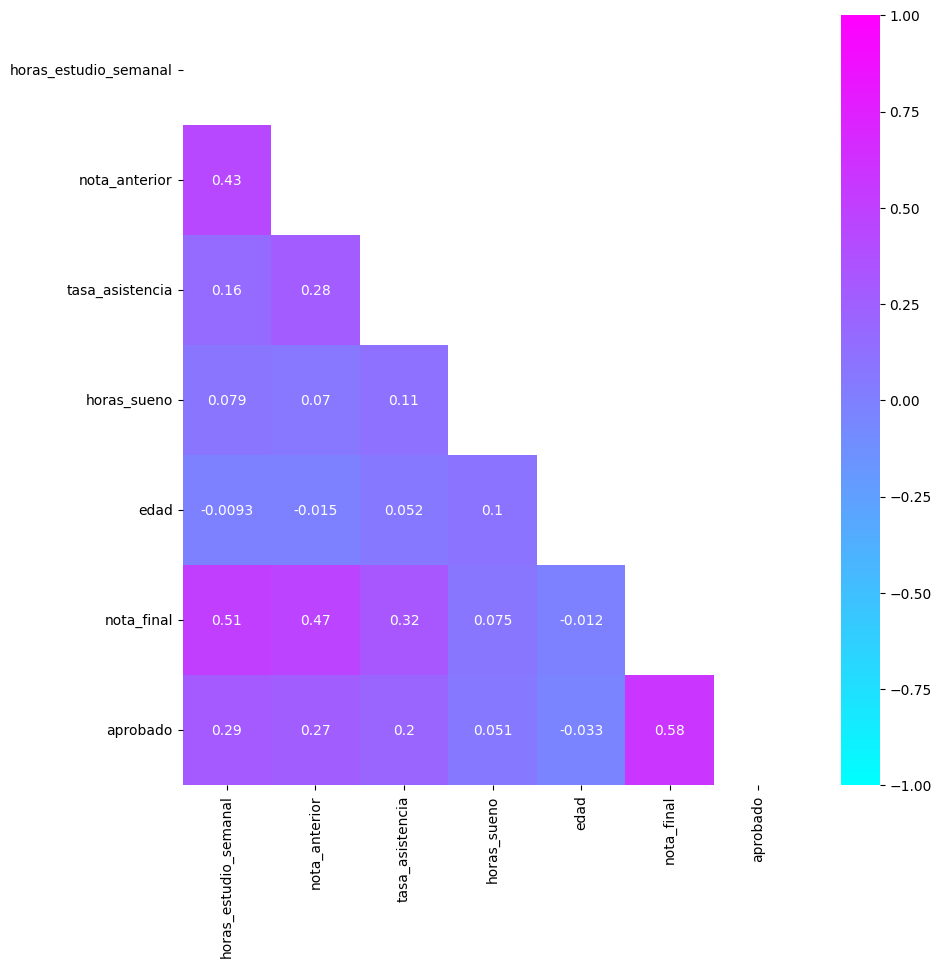

In [6]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            annot=True, 
            vmin=-1, 
            vmax=1, 
            mask=mask,
            cmap='cool')

plt.show()
# No existe gran correlacion entre las variables, pero si se puede observar que la variable 'promedio' tiene una correlacion positiva con 'examen_final' y 'examen_parcial', lo que indica que a mayor promedio, mayor puntaje en los examenes.

# Preprocesado

In [7]:
new_columns = []
for columna in df.columns:
    new_columns.append(columna.replace(' ', '_').upper())
df.columns = new_columns

In [8]:
num_cols = df.select_dtypes(include=np.number).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols, cat_cols

(Index(['HORAS_ESTUDIO_SEMANAL', 'NOTA_ANTERIOR', 'TASA_ASISTENCIA',
        'HORAS_SUENO', 'EDAD', 'NOTA_FINAL', 'APROBADO'],
       dtype='object'),
 Index(['NIVEL_DIFICULTAD', 'TIENE_TUTOR', 'HORARIO_ESTUDIO_PREFERIDO',
        'ESTILO_APRENDIZAJE'],
       dtype='object'))

In [9]:
(df.isna().sum() / df.shape[0]) * 100

HORAS_ESTUDIO_SEMANAL         0.0
NOTA_ANTERIOR                 0.0
TASA_ASISTENCIA               0.0
HORAS_SUENO                  15.0
EDAD                          0.0
NIVEL_DIFICULTAD              0.0
TIENE_TUTOR                   0.0
HORARIO_ESTUDIO_PREFERIDO    10.0
ESTILO_APRENDIZAJE            5.0
NOTA_FINAL                    0.0
APROBADO                      0.0
dtype: float64

In [10]:
for col in ['HORAS_SUENO']:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

for col in ['HORARIO_ESTUDIO_PREFERIDO', 'ESTILO_APRENDIZAJE']: 
    df[col] = df[col].fillna('Unknown')

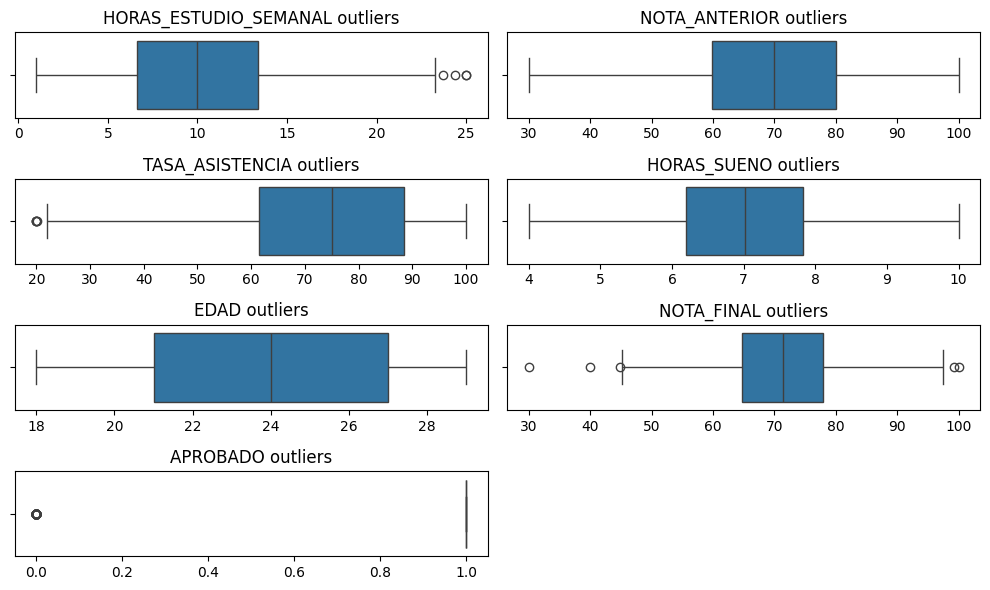

In [11]:
# Visualización de outliers en variables numéricas mediante diagramas de caja

df_num = df.select_dtypes(include=np.number)
cols_num = df_num.columns

n_plots = len(cols_num)
num_rows = math.ceil(n_plots / 2)  # Se distribuyen en 2 columnas

width = 5 * 2
height = 1.5 * num_rows
size = (width, height)

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=size)
axes = axes.flat  

for i, col in enumerate(cols_num):
   sns.boxplot(
       x=col,
       data=df_num,
       ax=axes[i]
   )

   axes[i].set_title(f'{col} outliers')
   axes[i].set_xlabel('')  

if n_plots % 2 != 0:
   fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Codificación

### Regresion

In [12]:
df_copy_reg = df.copy()
tv = 'NOTA_FINAL' # Variable objetivo para regresion

In [13]:
cat_cols = cat_cols.to_list()
cat_cols

['NIVEL_DIFICULTAD',
 'TIENE_TUTOR',
 'HORARIO_ESTUDIO_PREFERIDO',
 'ESTILO_APRENDIZAJE']

In [14]:
# Se decide usar target encoding para las variables categóricas
target_cols = [x for x in cat_cols]

In [15]:
target_encoder = TargetEncoder(cols=target_cols)
df_copy_reg[target_cols] = target_encoder.fit_transform(df_copy_reg[target_cols], df_copy_reg[tv])

In [16]:
scaler = MinMaxScaler()
df_copy_reg[df_copy_reg.drop(columns=[tv]).columns] = scaler.fit_transform(df_copy_reg.drop(columns=[tv]))

In [17]:
df_copy_reg.to_csv('df_regresion_dataproject.csv')

### Clasificación

In [18]:
df_copy_clas = df.copy()
tv = 'APROBADO' # Variable objetivo para clasificacion

In [19]:
target_cols = [x for x in cat_cols if x != 'APROBADO']
target_cols

['NIVEL_DIFICULTAD',
 'TIENE_TUTOR',
 'HORARIO_ESTUDIO_PREFERIDO',
 'ESTILO_APRENDIZAJE']

In [20]:
target_encoder = TargetEncoder(cols = target_cols)
df_copy_clas[target_cols] = target_encoder.fit_transform(df_copy_clas[target_cols], df_copy_clas[tv])
scaler = MinMaxScaler()
df_copy_clas[df_copy_clas.columns] = scaler.fit_transform(df_copy_clas)

In [21]:
df_copy_clas.to_csv('df_clasificacion_dataproject.csv')